# Detección de Objetos con SSD

**Objetivo:** Antes de saltar a la arquitectura YOLO, exploraremos otro influyente detector de un solo paso: SSD (Single Shot MultiBox Detector). Entenderemos su enfoque único para detectar objetos de diferentes tamaños y lo pondremos a prueba con nuestro conjunto de imágenes.

### 1. SSD: Una Alternativa de Detección en Un Solo Paso

SSD, al igual que YOLO, es un detector de un solo paso, lo que significa que realiza la localización y clasificación en una sola pasada por la red. Sin embargo, su principal innovación radica en cómo maneja la detección de objetos a diferentes escalas.

**¿Cómo funciona?**

1.  **Backbone y Mapas de Características a Múltiples Escalas:** SSD utiliza una red convolucional base (como VGG o MobileNet) para extraer características. A diferencia de otros modelos que solo usan el mapa de características final, SSD toma "instantáneas" de los mapas de características en diferentes etapas de la red (tempranas, intermedias y tardías). Los mapas tempranos (más grandes) son útiles para detectar objetos pequeños, mientras que los mapas tardíos (más pequeños y profundos) son mejores para detectar objetos grandes.

2.  **Cajas de Anclaje (Anchor Boxes):** En cada ubicación de estos mapas de características, SSD coloca un conjunto de cajas delimitadoras predeterminadas, llamadas **anchor boxes** (o cajas de anclaje). Estas cajas tienen diferentes tamaños y relaciones de aspecto (unas son cuadradas, otras altas, otras anchas).

3.  **Predicción de Desplazamientos y Clases:** En lugar de predecir un cuadro desde cero, la red aprende a predecir dos cosas para cada caja de anclaje:
    -   **Desplazamientos (Offsets):** Qué tanto debe ajustar (mover, escalar) la caja de anclaje para que se ajuste perfectamente al objeto real.
    -   **Puntuaciones de Clase:** La probabilidad de que esa caja (una vez ajustada) contenga cada uno de los objetos posibles (más una clase para "fondo").

![Diagrama conceptual de SSD](images/ssd_architecture.png)

*SSD utiliza mapas de características de diferentes capas del backbone para predecir objetos de distintos tamaños.*

### 2. Práctica: Detección con un Modelo SSD Pre-entrenado

Para esta práctica, utilizaremos un modelo SSD pre-entrenado disponible en **TensorFlow Hub**, un repositorio de modelos de machine learning listos para usar. Esto nos permite aplicar un modelo potente sin necesidad de entrenarlo desde cero.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from PIL import Image
import requests
import matplotlib.pyplot as plt

In [2]:
# Paso 3: Cargar el modelo SSD desde TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
detector = hub.load(model_url)

### 3. Función Auxiliar para Detección y Visualización

Crearemos una función que tome la URL de una imagen, la procese con nuestro detector SSD y dibuje los resultados. El proceso es un poco más manual que con la librería `ultralytics`, lo que nos permite ver qué sucede internamente.

In [3]:
def detect_with_ssd(image_url):
    """Toma la URL de una imagen, la procesa con SSD y muestra los resultados."""
    try:
        # Descargar y leer la imagen
        resp = requests.get(image_url, stream=True)
        image_np = np.frombuffer(resp.raw.read(), np.uint8)
        image_np = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        
        # Convertir a tensor y añadir una dimensión de batch
        input_tensor = tf.convert_to_tensor(image_np)
        input_tensor = input_tensor[tf.newaxis, ...]
        
        # Realizar la detección
        results = detector(input_tensor)
        
        # Procesar los resultados
        result = {key:value.numpy() for key,value in results.items()}
        
        # Dibujar los cuadros delimitadores en la imagen
        scores = result['detection_scores'][0]
        boxes = result['detection_boxes'][0]
        
        for i in range(len(scores)):
            if scores[i] > 0.5: # Umbral de confianza del 50%
                ymin, xmin, ymax, xmax = boxes[i]
                h, w, _ = image_np.shape
                (left, right, top, bottom) = (xmin * w, xmax * w, ymin * h, ymax * h)
                cv2.rectangle(image_np, (int(left), int(top)), (int(right), int(bottom)), (255, 0, 0), 2)
        
        # Mostrar la imagen
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"No se pudo procesar la imagen desde {image_url}. Error: {e}")

### 4. Probando el Modelo con Nuestros Ejemplos

Ahora, usemos nuestra función con la misma lista de imágenes que usaremos para YOLO.

--- Procesando imagen con SSD: https://ultralytics.com/images/bus.jpg... ---


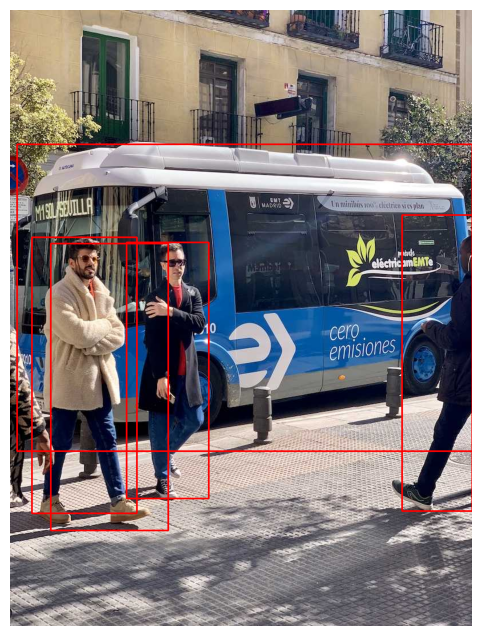

--- Procesando imagen con SSD: https://ultralytics.com/images/zidane.jpg... ---


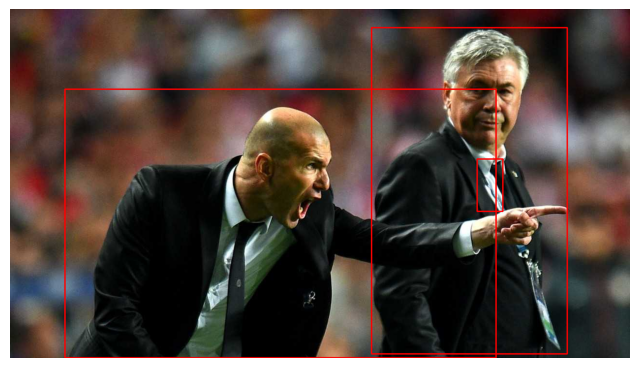

--- Procesando imagen con SSD: https://images.pexels.com/photos/1099680/pexels-ph... ---


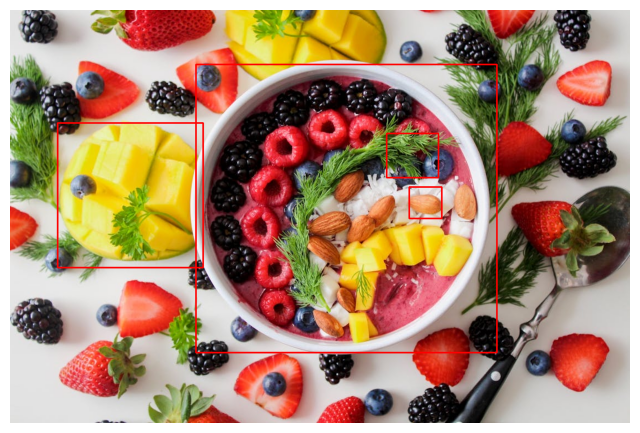

--- Procesando imagen con SSD: https://images.pexels.com/photos/1571460/pexels-ph... ---


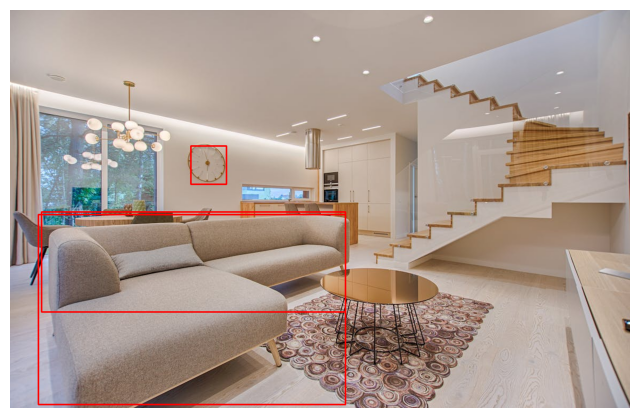

--- Procesando imagen con SSD: https://images.pexels.com/photos/3785931/pexels-ph... ---


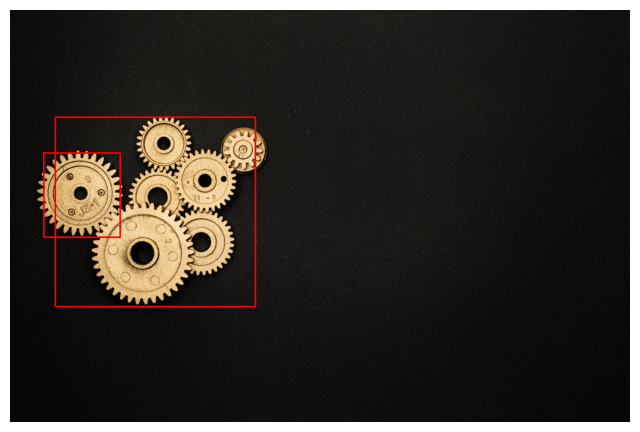

In [4]:
image_urls = [
    'https://ultralytics.com/images/bus.jpg',
    'https://ultralytics.com/images/zidane.jpg',
    'https://images.pexels.com/photos/1099680/pexels-photo-1099680.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
    'https://images.pexels.com/photos/1571460/pexels-photo-1571460.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
    'https://images.pexels.com/photos/3785931/pexels-photo-3785931.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
]

for url in image_urls:
    print(f"--- Procesando imagen con SSD: {url[:50]}... ---")
    detect_with_ssd(url)

### 5. Conclusiones sobre SSD

Como podemos ver, el modelo SSD es capaz de detectar muchos de los objetos clave en las imágenes. Sin embargo, podemos notar algunas diferencias con detectores más modernos:

- **Precisión:** Aunque es bueno, puede que falle en detectar objetos más pequeños o que tenga más detecciones incorrectas (falsos positivos) en comparación con arquitecturas más recientes.
- **Simplicidad vs. Rendimiento:** SSD fue un hito por su balance entre velocidad y precisión. Su concepto de usar mapas de características a múltiples escalas es fundamental y ha influenciado a muchas arquitecturas posteriores, incluyendo a YOLO.

Entender SSD nos da una base sólida para apreciar las innovaciones que YOLO trajo después, especialmente en la forma en que el "Neck" de la red refina y combina estas características de múltiples escalas para lograr un rendimiento aún mayor. Ahora, estamos listos para ver a YOLO en acción y comparar los resultados.

### Referencias Bibliográficas

* **SSD:** Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016). [*SSD: Single shot multibox detector.*](https://arxiv.org/pdf/1512.02325.pdf)